# Airbyte SQL Index Guide

We will show how to generate SQL queries on a Snowflake db generated by Airbyte.

In [1]:
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

### Airbyte ingestion

Here we show how to ingest data from Zendesk into a Snowflake db using Airbyte.

TODO: Airbyte to add better screenshots.

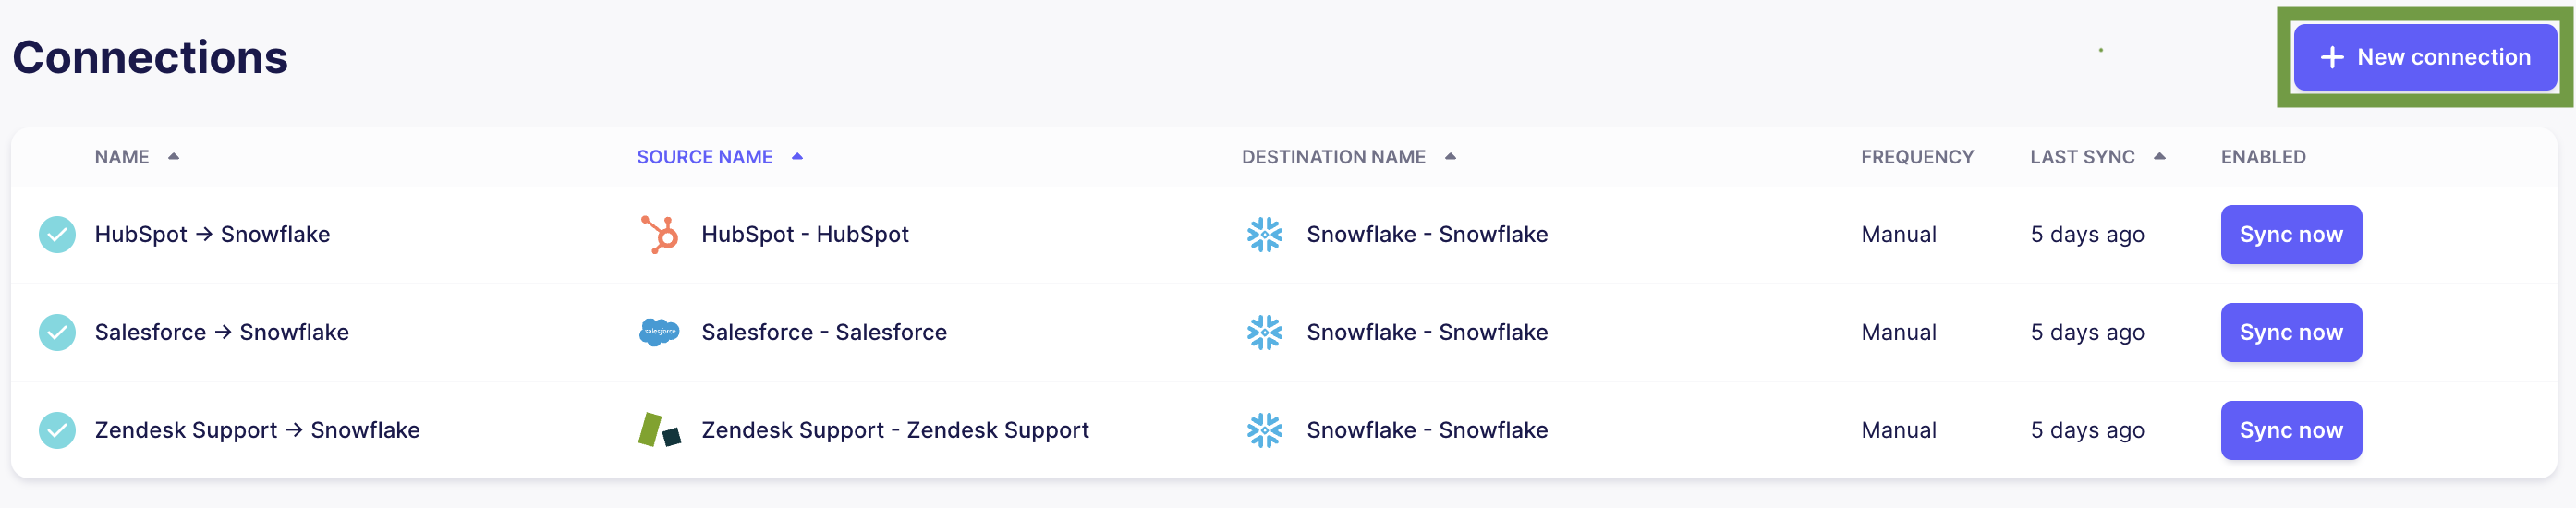

Let's create a new connection. Here we will be dumping our Zendesk tickets into a Snowflake db.

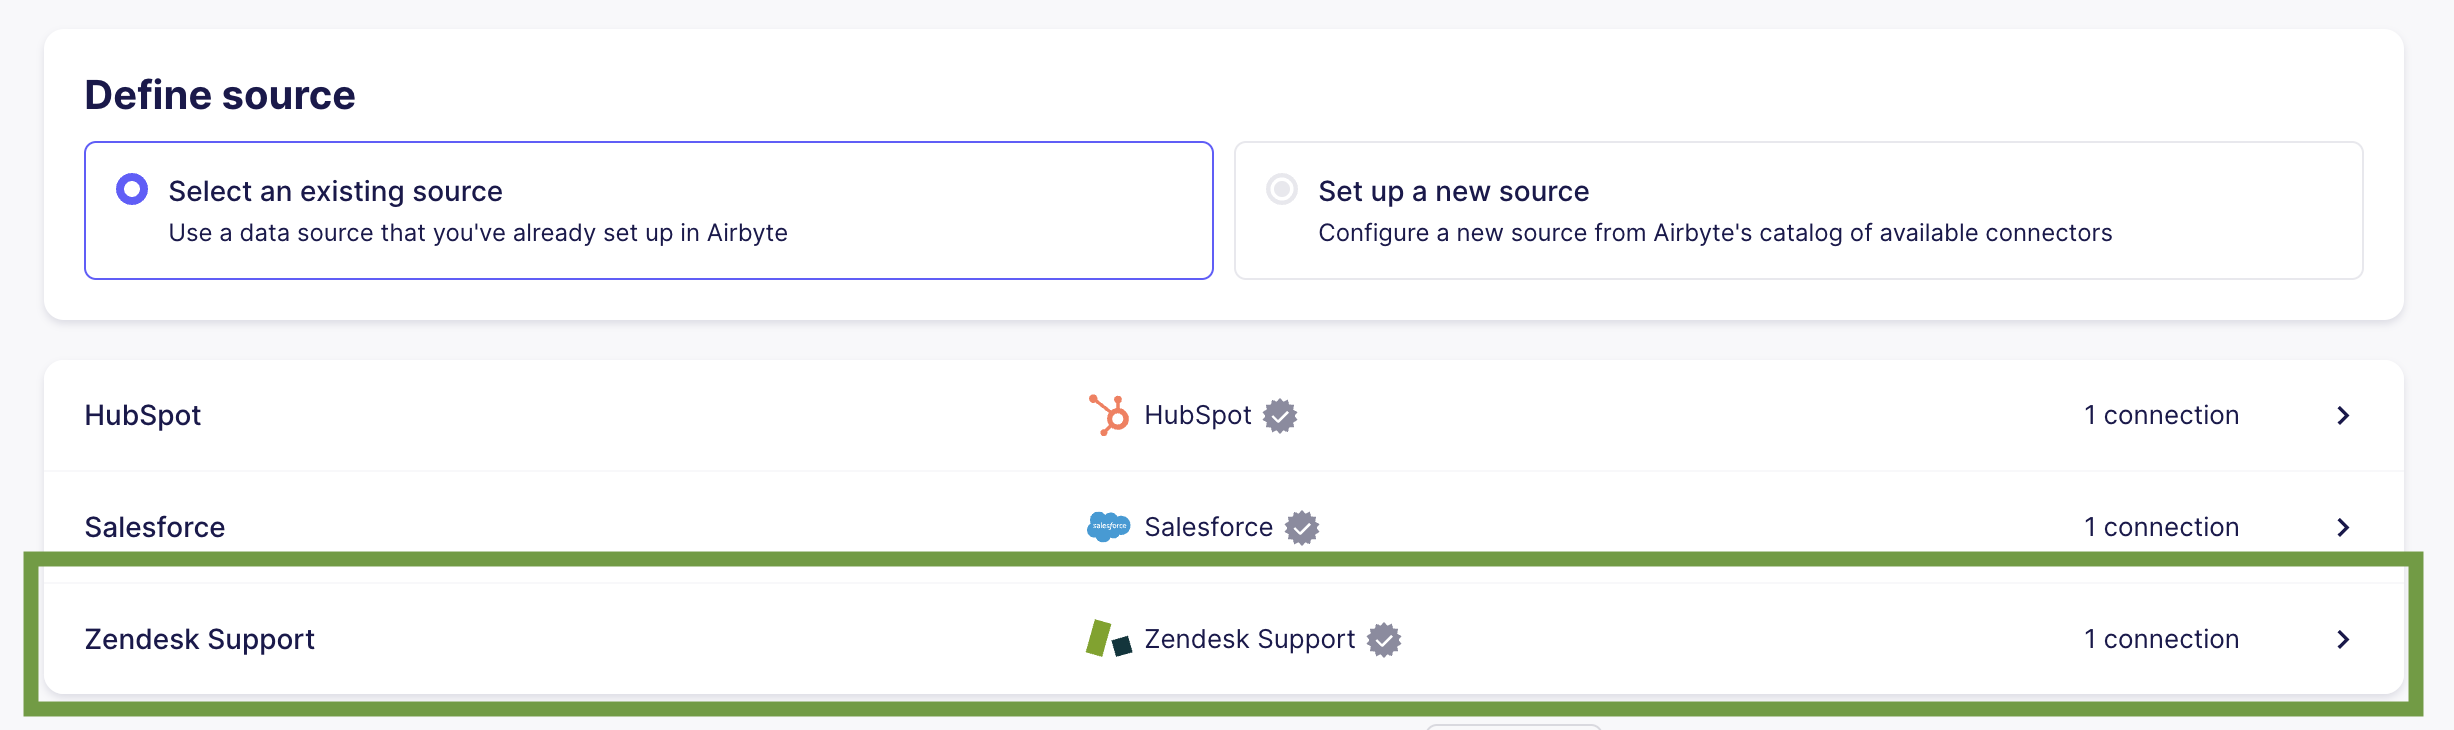

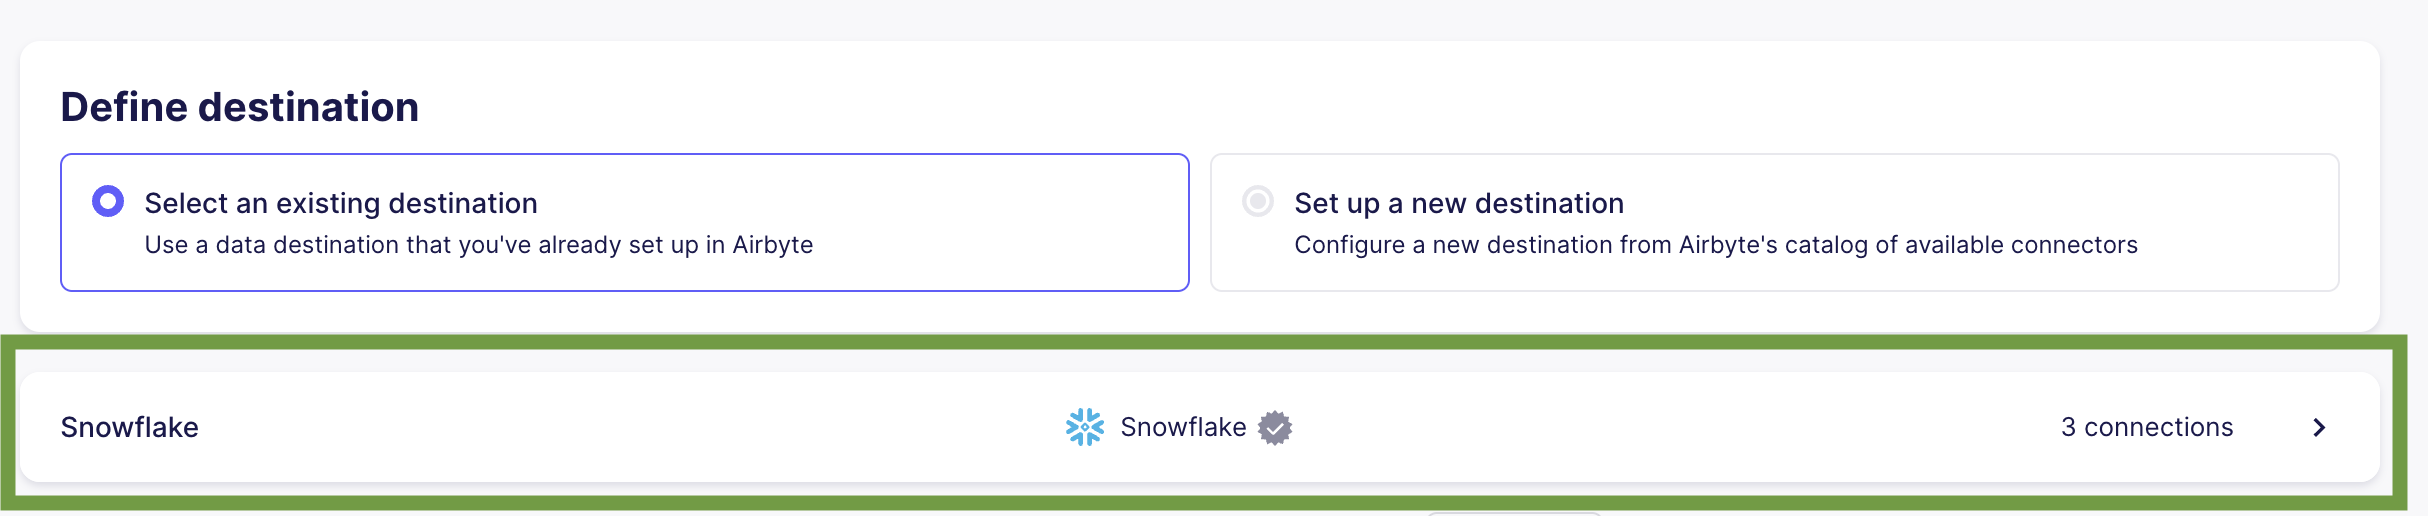

Choose the fields you want to sync.
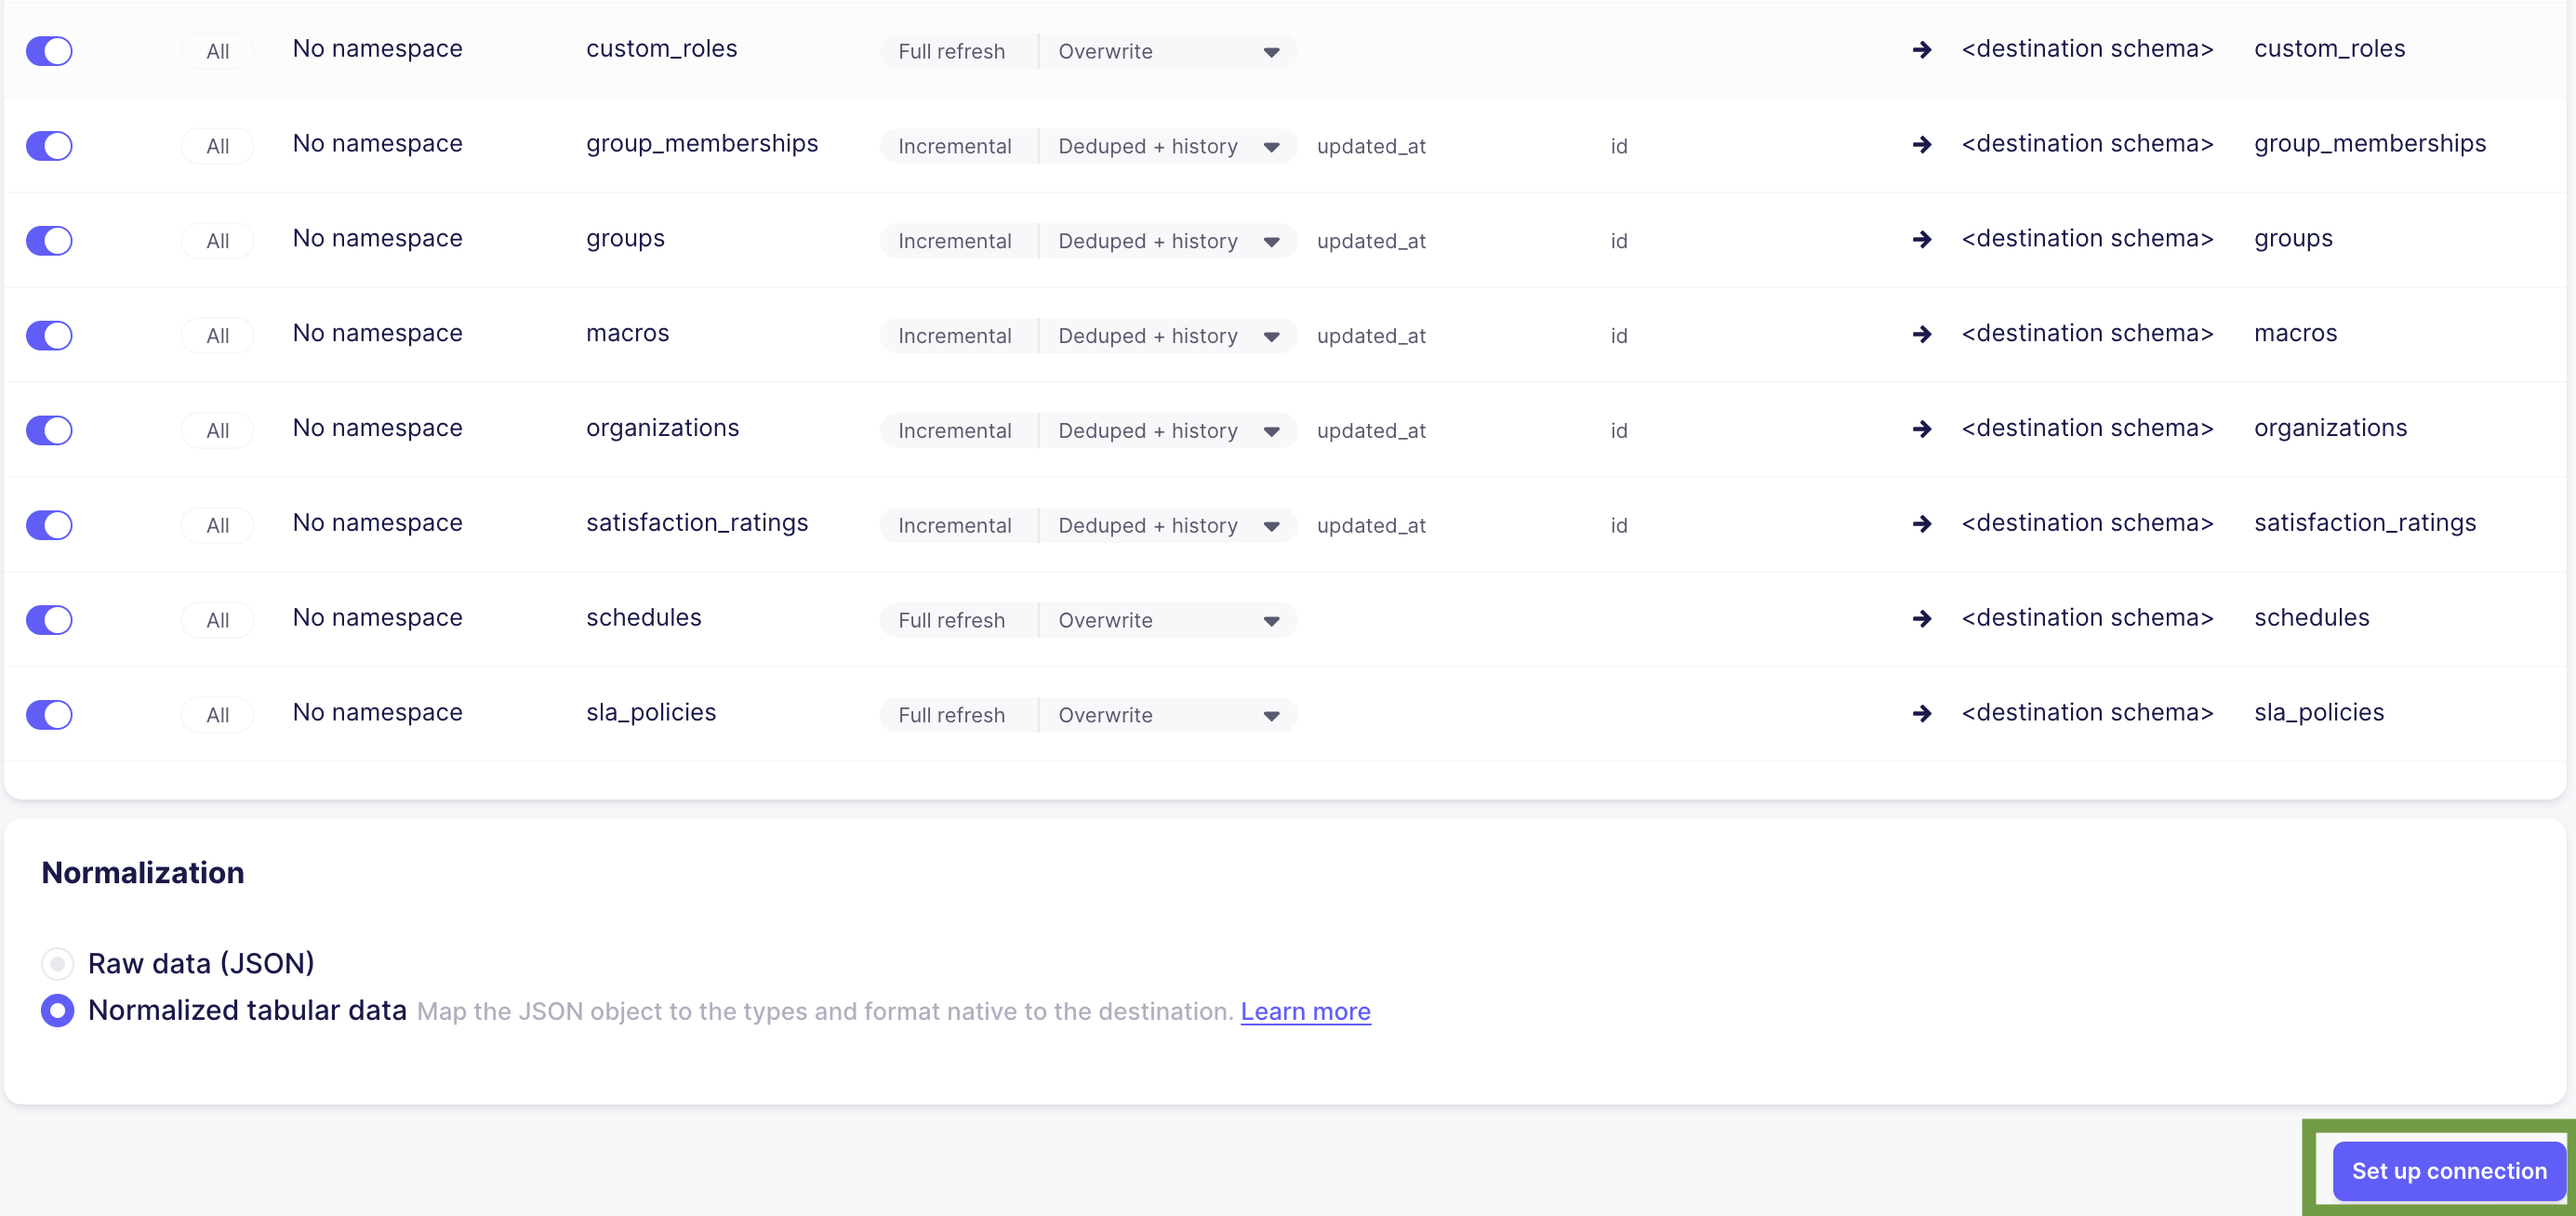

Sync your data.
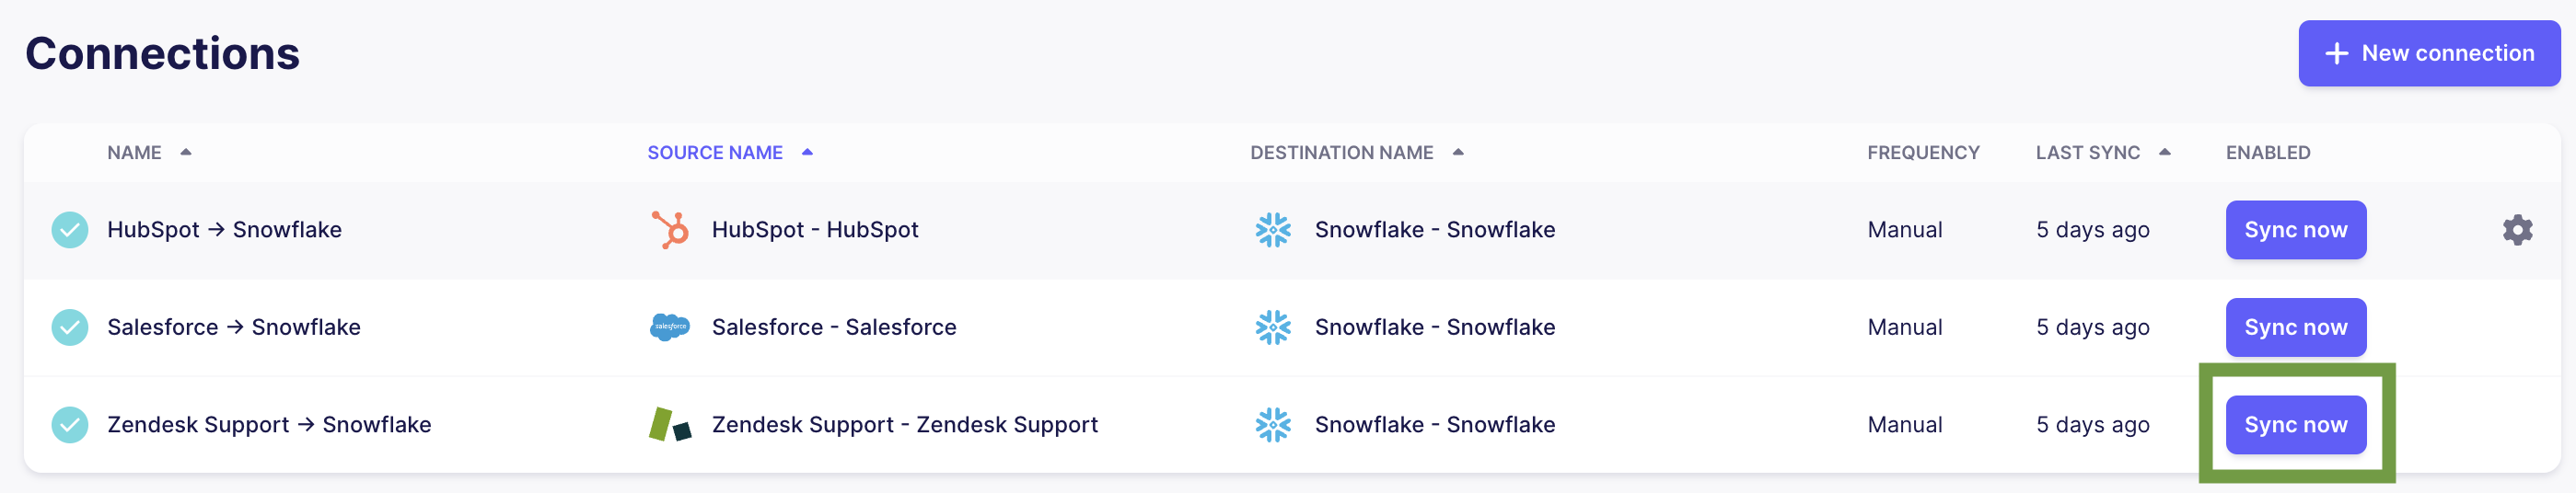

### Snowflake-SQLAlchemy version fix

Hack to make snowflake-sqlalchemy work despite incompatible sqlalchemy versions

Taken from https://github.com/snowflakedb/snowflake-sqlalchemy/issues/380#issuecomment-1470762025

In [2]:
# Hack to make snowflake-sqlalchemy work until they patch it

def snowflake_sqlalchemy_20_monkey_patches():
    import sqlalchemy.util.compat

    # make strings always return unicode strings
    sqlalchemy.util.compat.string_types = (str,)
    sqlalchemy.types.String.RETURNS_UNICODE = True

    import snowflake.sqlalchemy.snowdialect

    snowflake.sqlalchemy.snowdialect.SnowflakeDialect.returns_unicode_strings = True

    # make has_table() support the `info_cache` kwarg
    import snowflake.sqlalchemy.snowdialect

    def has_table(self, connection, table_name, schema=None, info_cache=None):
        """
        Checks if the table exists
        """
        return self._has_object(connection, "TABLE", table_name, schema)

    snowflake.sqlalchemy.snowdialect.SnowflakeDialect.has_table = has_table

# usage: call this function before creating an engine:
try:
    snowflake_sqlalchemy_20_monkey_patches()
except Exception as e:
    raise ValueError("Please run `pip install snowflake-sqlalchemy`")

/Users/hongyishi/Documents/GitHub/gpt_index/.venv/lib/python3.9/site-packages/snowflake/connector/options.py:108: UserWarning: You have an incompatible version of 'pyarrow' installed (12.0.1), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


### Define database

We pass the Snowflake uri to the SQL db constructor
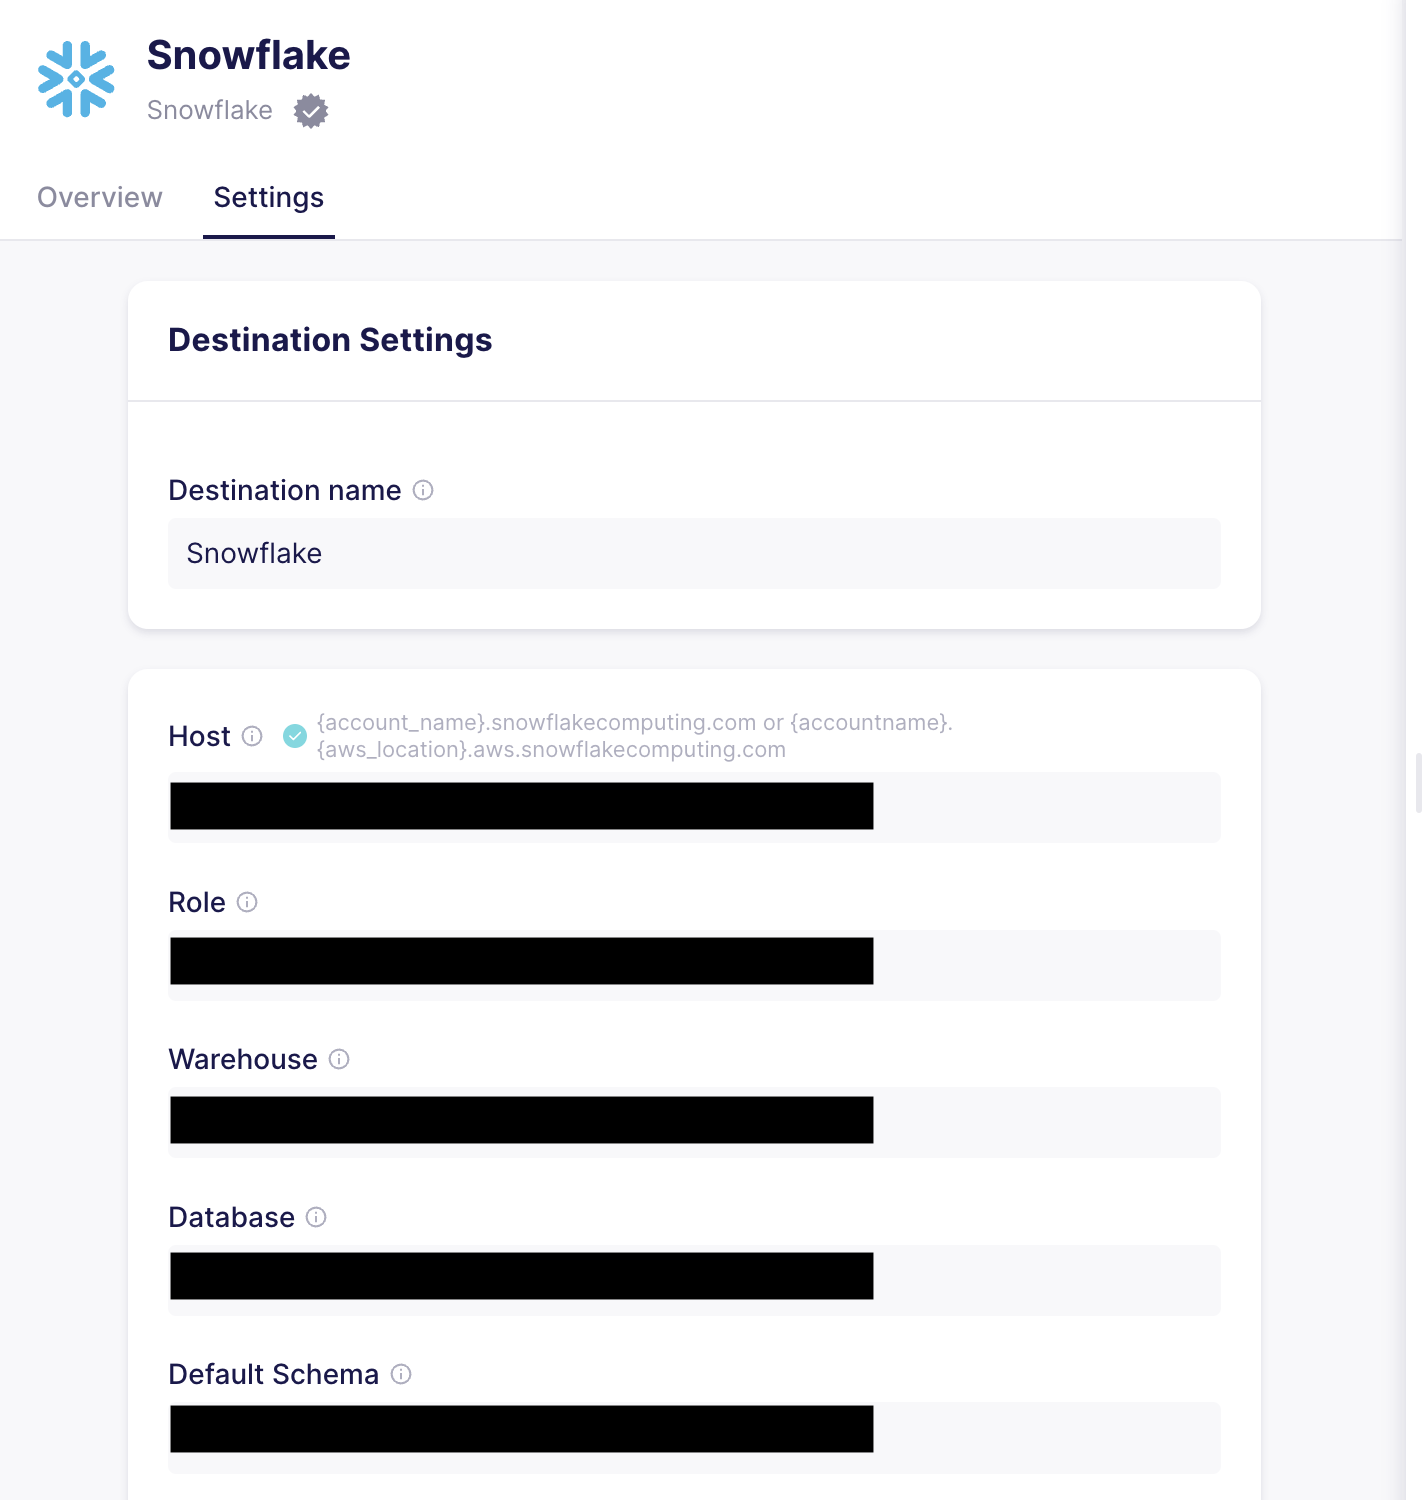

In [3]:
snowflake_uri = 'snowflake://<user_login_name>:<password>@<account_identifier>/<database_name>/<schema_name>?warehouse=<warehouse_name>&role=<role_name>'


First we try connecting with sqlalchemy to check the db works.

In [4]:
from sqlalchemy import select, create_engine, MetaData, Table

# view current table
engine = create_engine(snowflake_uri)
metadata = MetaData(bind=None)
table = Table(
    'ZENDESK_TICKETS', 
    metadata, 
    autoload=True, 
    autoload_with=engine
)
stmt = select(table.columns)


with engine.connect() as connection:
    results = connection.execute(stmt).fetchone()
    print(results)
    print(results.keys())


/var/folders/dx/n9yhm8p9039b5bgmgjqy46y40000gn/T/ipykernel_58468/3609487787.py:6: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  table = Table(


(False, 'test case', '[]', datetime.datetime(2022, 7, 18, 16, 59, 13, tzinfo=<UTC>), 'test to', None, None, 'question', '{\n  "channel": "web",\n  "source": {\n    "from": {},\n    "rel": null,\n    "to": {}\n  }\n}', True, datetime.datetime(2022, 7, 18, 18, 1, 37, tzinfo=<UTC>), None, '[]', None, 134, None, 1658167297, 'test case', None, '[]', False, '{\n  "score": "offered"\n}', 360786799676, 'low', '[]', 'https://d3v-airbyte.zendesk.com/api/v2/tickets/134.json', '[]', 360000358316, 360000084116, '[]', None, '[]', 360033549136, True, None, False, 'new', 360786799676, 'abd39a87-b1f9-4390-bf8b-cf3c288b1f74', datetime.datetime(2023, 6, 9, 0, 25, 23, 501000, tzinfo=pytz.FixedOffset(-420)), datetime.datetime(2023, 6, 9, 0, 38, 20, 440000, tzinfo=<UTC>), '6577ef036668746df889983970579a55', '02522a2b2726fb0a03bb19f2d8d9524d')
RMKeyView(['from_messaging_channel', 'subject', 'email_cc_ids', 'created_at', 'description', 'custom_status_id', 'external_id', 'type', 'via', 'allow_attachments', 'up

### Build Index

We then build the SQL Index (`SQLStructStoreIndex`).

In [5]:
from llama_index import SQLStructStoreIndex, SQLDatabase, VectorStoreIndex
from llama_index.indices.struct_store import SQLContextContainerBuilder

# NOTE: the table_name specified here is the table that you
# want to extract into from unstructured documents.
sql_database = SQLDatabase(engine)
context_builder = SQLContextContainerBuilder(sql_database)
table_schema_index = context_builder.derive_index_from_context(
    VectorStoreIndex,
)
query_str = "When was the last ticket created?"
context_builder.query_index_for_context(table_schema_index, query_str, store_context_str=True)
context_container = context_builder.build_context_container()
index = SQLStructStoreIndex(
    sql_database=sql_database,
    sql_context_container=context_container,
)

Note that we add the context_container to restrict the prompt to only querying over the most relevant tables.
Otherwise we will get size overflow on our query.

### Query Index

We first show how we can execute a raw SQL query, which directly executes over the table.

In [6]:
query_engine = index.as_query_engine(
    query_mode="sql"
)
response = query_engine.query("SELECT created_at FROM ZENDESK_TICKETS limit 5")

In [7]:
from IPython.display import Markdown, display
display(Markdown(f"<b>{response}</b>"))

<b>[(datetime.datetime(2022, 7, 18, 16, 59, 13, tzinfo=<UTC>),), (datetime.datetime(2021, 9, 1, 11, 59, 40, tzinfo=<UTC>),), (datetime.datetime(2021, 9, 1, 12, 0, 29, tzinfo=<UTC>),), (datetime.datetime(2022, 7, 18, 15, 22, 39, tzinfo=<UTC>),), (datetime.datetime(2021, 9, 1, 12, 0, 25, tzinfo=<UTC>),)]</b>

We then show a natural language query, which is translated to a SQL query under the hood with our text-to-SQL prompt.

In [8]:

query_engine = index.as_query_engine()
display(Markdown(f"<b>{context_container.context_str}</b>"))
response = query_engine.query(query_str)

<b>
Table 'hubspot_tickets' has the relevant column for the query: createdat (TIMESTAMP_TZ). The full schema of the table is: archived (BOOLEAN), createdat (TIMESTAMP_TZ), companies (VARIANT), deals (VARIANT), id (VARCHAR(16777216)), contacts (VARIANT), properties (VARIANT), updatedat (TIMESTAMP_TZ), _airbyte_ab_id (VARCHAR(16777216)), _airbyte_emitted_at (TIMESTAMP_TZ), _airbyte_normalized_at (TIMESTAMP_TZ), _airbyte_hubspot_tickets_hashid (VARCHAR(32)), _airbyte_unique_key (VARCHAR(32)) and foreign keys: .</b>

In [9]:
display(Markdown(f"<b>{response}</b>"))

<b> The last ticket was created on January 30th, 2023 at 11:52 PM UTC.</b>

In [10]:
# you can also fetch the raw result from SQLAlchemy! 
response.extra_info["result"]

[(datetime.datetime(2023, 1, 30, 23, 52, 42, 464000, tzinfo=<UTC>),)]